In [1]:
import os
import pickle
import random
import glob
import datetime
import pandas as pd
import numpy as np
import cv2
import pydicom
from tqdm import tqdm
from joblib import delayed, Parallel
import zipfile
from pydicom.filebase import DicomBytesIO
import sys
from PIL import Image
import cv2
#from focal_loss import sparse_categorical_focal_loss
import keras
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3

# importing pyplot and image from matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from keras.optimizers import SGD
from keras import backend
from keras.models import load_model

from keras.preprocessing import image
import albumentations as A


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from tensorflow.keras.losses import Reduction

from tensorflow_addons.losses import SigmoidFocalCrossEntropy

In [3]:
base_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train/'
TEST_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_test/'
image_dir = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/png/train/adjacent-brain-cropped/'
save_dir = 'home/ubuntu/kaggle/models/'
os.listdir(base_url)

def png(image): 
    return image + '.png'

# learning rate scheduler

In [4]:
initial_learning_rate = 1e-2
first_decay_steps = 300
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate,
      first_decay_steps))
opt = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)

# Weighted metrics

In [5]:
from tensorflow.keras import backend as K
def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)



# Data generator

In [6]:
train_idg = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,
        rescale=1./255)
valid_idg = ImageDataGenerator(rescale=1./255)
training_data = pd.read_csv(f'train_0.csv') 
training_data['Image'] = training_data['Image'].apply(png)

validation_data = pd.read_csv(f'valid_0.csv')
validation_data['Image'] = validation_data['Image'].apply(png)

columns=['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']

#train_data_generator = train_idg.flow_from_dataframe(training_data, directory = image_dir,
#                           x_col = "Image", y_col = columns,batch_size=64,
#                           class_mode="raw", target_size=(224,224), shuffle = True)
#valid_data_generator  = valid_idg.flow_from_dataframe(validation_data, directory = image_dir,
#                        x_col = "Image", y_col = columns,batch_size=64,
#                        class_mode = "raw",target_size=(224,224), shuffle = False)

# under-sampling

In [7]:
def undersample(dataframe,steps,batch_size):
        part = np.int(steps/3 * batch_size)
        zero_ids = np.random.choice(dataframe.loc[dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(dataframe.loc[dataframe["any"] == 1].index.values, size=1*part, replace=False)
        data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(data_ids)
        return data_ids
        

In [8]:
train_indices = undersample(training_data, 8050,32)
print(len(train_indices))

257598


In [9]:
valid_indices = undersample(validation_data, 2010,32)
print(len(valid_indices))

64320


In [10]:
l = training_data[training_data.index.isin(train_indices)]
m = validation_data[validation_data.index.isin(valid_indices)]

In [11]:
z = l[['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']]

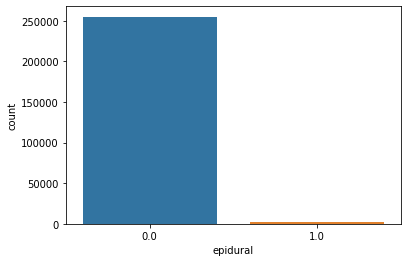

In [12]:
import seaborn as sns
sns.countplot(z.iloc[:,1])

In [13]:
q = z.iloc[:,1]
q[q==1].value_counts()

1.0    2553
Name: epidural, dtype: int64

In [14]:
train_under_generator = train_idg.flow_from_dataframe(l, directory = image_dir,
                           x_col = "Image", y_col = columns,batch_size=32,
                           class_mode="raw", target_size=(224,224), shuffle = True)
valid_under_generator  = valid_idg.flow_from_dataframe(m, directory = image_dir,
                        x_col = "Image", y_col = columns,batch_size=32,
                        class_mode = "raw",target_size=(224,224), shuffle = False)

Found 257598 validated image filenames.
Found 64320 validated image filenames.


# model

In [34]:
from tensorflow.keras.applications.densenet import DenseNet169
#base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers[:-7]:
    print(layer)

In [31]:
from tensorflow.keras.applications.densenet import DenseNet169
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
      
]







# create the base pre-trained model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224,224,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
#x = Dropout(0.3)(x)
#x = Dense(100, activation="relu")(x)
#x = Dropout(0.3)(x)
#pred = Dense(6,
#             kernel_initializer=tf.keras.initializers.HeNormal(seed=11),
#             kernel_regularizer=tf.keras.regularizers.l2(0.05),
#             bias_regularizer=tf.keras.regularizers.l2(0.05), activation="softmax")(x)
#initializer = keras.initializers.GlorotUniform()
#layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

predictions = Dense(6, activation='sigmoid')(x)
#activation='sigmoid',kernel_initializer=keras.initializers.GlorotNormal()
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False



# compile the model (should be done *after* setting layers to non-trainable)
model.compile(opt, loss='binary_crossentropy', metrics=METRICS)
#model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=METRICS)
#model.compile(loss=loss_func,
#          optimizer=opt,
#          metrics=METRICS)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

# callbacks

In [32]:
from keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint = tf.keras.callbacks.ModelCheckpoint('densenet169_{epoch:08d}.h5', period=1,mode= 'auto',save_best_only=True) 

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callback_list = [checkpoint]


In [33]:
tf.config.experimental_run_functions_eagerly(True)

In [34]:
class_weight = {0:1.0,1:1.5}
class_weight

{0: 1.0, 1: 1.5}

# fit

In [35]:



num_epochs = 3

batch_size = 32
training_steps = len(train_under_generator) // batch_size
validation_step = len(valid_under_generator) // batch_size




# FIT THE MODEL
history = model.fit(train_under_generator,
            epochs=num_epochs,steps_per_epoch=training_steps,
            callbacks=callback_list,
            class_weight=class_weight,
            validation_data=valid_under_generator,
            validation_steps= validation_step,workers=-1) 





tf.keras.backend.clear_session()


Epoch 1/3
251/251 [==============================] - 224s 894ms/step - loss: 1.3349 - tp: 1679.0000 - fp: 1131.0000 - tn: 40524.0000 - fn: 4858.0000 - accuracy: 0.8757 - precision: 0.5975 - recall: 0.2568 - auc: 0.6654 - val_loss: 1.4346 - val_tp: 362.0000 - val_fp: 87.0000 - val_tn: 10094.0000 - val_fn: 1361.0000 - val_accuracy: 0.8784 - val_precision: 0.8062 - val_recall: 0.2101 - val_auc: 0.6627
Epoch 2/3
251/251 [==============================] - 224s 892ms/step - loss: 1.2703 - tp: 1741.0000 - fp: 795.0000 - tn: 40999.0000 - fn: 4657.0000 - accuracy: 0.8869 - precision: 0.6865 - recall: 0.2721 - auc: 0.6726 - val_loss: 1.4225 - val_tp: 480.0000 - val_fp: 160.0000 - val_tn: 10021.0000 - val_fn: 1243.0000 - val_accuracy: 0.8821 - val_precision: 0.7500 - val_recall: 0.2786 - val_auc: 0.6607
Epoch 3/3
251/251 [==============================] - 223s 890ms/step - loss: 1.2683 - tp: 1798.0000 - fp: 715.0000 - tn: 41038.0000 - fn: 4641.0000 - accuracy: 0.8889 - precision: 0.7155 - recall:

In [37]:
from tensorflow.keras.models import load_model
model = load_model('densenet169_freeze2.h5')

# Evaluation

In [ ]:
valid_data_generator  = valid_idg.flow_from_dataframe(validation_data, directory = image_dir,
                        x_col = "Image", y_col = columns,batch_size=64,
                        class_mode = "raw",target_size=(224,224), shuffle = False)

In [38]:
valid_predict =  model.evaluate_generator(valid_under_generator)
print(valid_predict)

Instructions for updating:
Please use Model.evaluate, which supports generators.


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


[0.23301322758197784, 22583.0, 6920.0, 328241.0, 28176.0, 0.9090583920478821, 0.7654475569725037, 0.4449063241481781, 0.9036330580711365]


In [39]:
model.metrics_names

['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']

In [40]:
print('\n---------------\n')
print('validation data **loss** value =', valid_predict[0])
print('\n---------------\n')
print('validation data **true positive** value = ', valid_predict[1])
print('\n---------------\n')
print('validation data **false positive** value =', valid_predict[2])
print('\n---------------\n')
print('validation data **true negative** value =', valid_predict[3])
print('\n---------------\n')
print('validation data **false negative** value =', valid_predict[4])
print('\n---------------\n')
print('validation data **accuracy** value = ', valid_predict[5])
print('\n---------------\n')
print('validation data **precision** value =', valid_predict[6])
print('\n---------------\n')
print('validation data **recall* value =', valid_predict[7])
print('\n---------------\n')
print('validation data **AUC* value =', valid_predict[8])
print('\n---------------\n')


---------------

validation data **loss** value = 0.23301322758197784

---------------

validation data **true positive** value =  22583.0

---------------

validation data **false positive** value = 6920.0

---------------

validation data **true negative** value = 328241.0

---------------

validation data **false negative** value = 28176.0

---------------

validation data **accuracy** value =  0.9090583920478821

---------------

validation data **precision** value = 0.7654475569725037

---------------

validation data **recall* value = 0.4449063241481781

---------------

validation data **AUC* value = 0.9036330580711365

---------------



In [60]:
y_true = m[['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']].reset_index(drop=True)

#Y_pred = model.predict_generator(valid_under_generator)
preds = np.where(Y_pred < 0.25, 0, 1)



#val = 0.25

#Y_pred[Y_pred>=val]=1
#Y_pred[Y_pred<val]=0

# classification matrix

In [61]:
print('Classification Report')
target_names = ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
print(classification_report(y_true, preds, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

             any       0.65      0.87      0.74     21440
        epidural       0.00      0.00      0.00       577
intraparenchymal       0.69      0.54      0.60      6898
intraventricular       0.66      0.55      0.60      5111
    subarachnoid       0.34      0.60      0.43      7202
        subdural       0.50      0.51      0.50      9531

       micro avg       0.56      0.68      0.61     50759
       macro avg       0.47      0.51      0.48     50759
    weighted avg       0.57      0.68      0.61     50759
     samples avg       0.24      0.22      0.22     50759



# confusion metrics

In [62]:
mlb = ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']

from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true,preds)

array([[[32873, 10007],
        [ 2882, 18558]],

       [[63739,     4],
        [  577,     0]],

       [[55725,  1697],
        [ 3207,  3691]],

       [[57765,  1444],
        [ 2306,  2805]],

       [[48512,  8606],
        [ 2849,  4353]],

       [[49812,  4977],
        [ 4644,  4887]]])

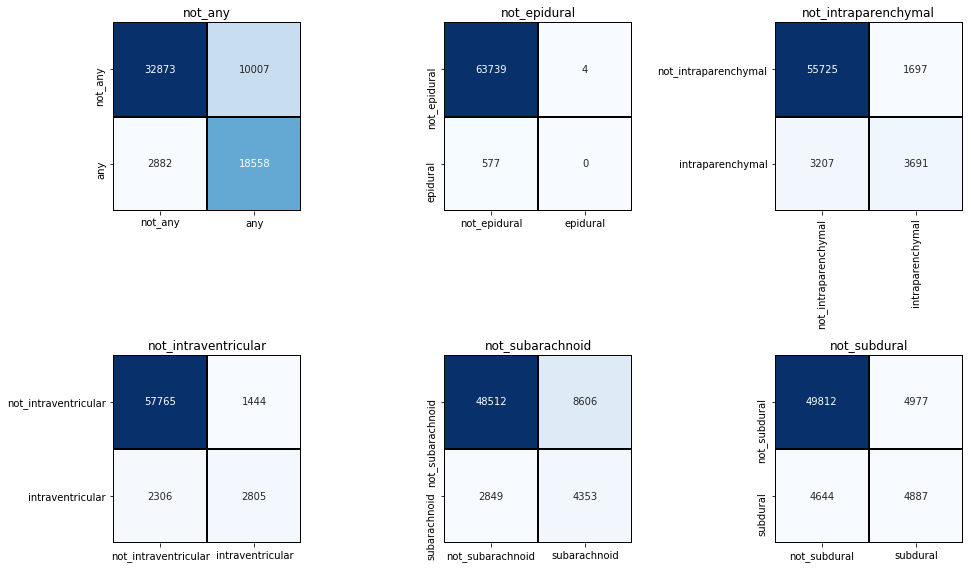

In [63]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(y_true, preds)

# Plot confusion matrix 
fig = plt.figure(figsize = (14, 8))
for i, (label, matrix) in enumerate(zip(mlb, confusion)):
    plt.subplot(f'23{i+1}')
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

# auc_roc_curve

In [64]:
auc = roc_auc_score(y_true, preds)
print(auc)

0.711479530880815


# training accuracy and loss

In [46]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    with plt.xkcd():
        plt.figure(figsize = (10,10))
        plt.plot(H.epoch,H.history["accuracy"], label="train_acc")
        plt.plot(H.epoch,H.history["val_accuracy"], label="val_acc")
        plt.title("Training Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower left")
        plt.show()

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


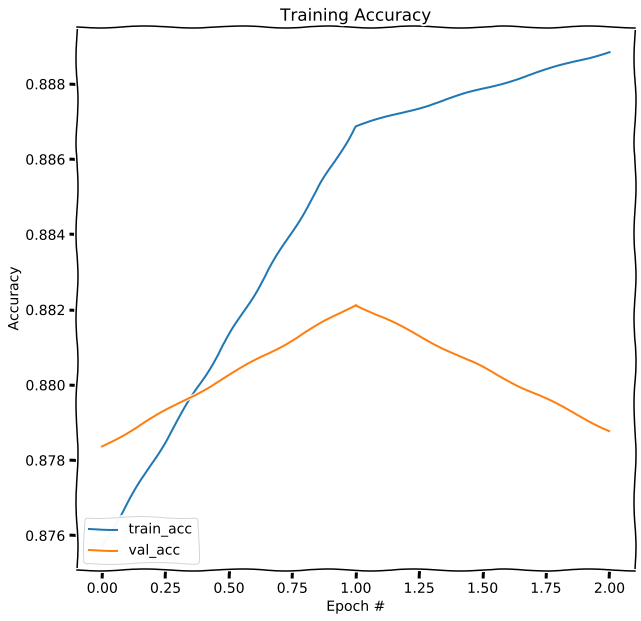

In [47]:
plot_training(history)

In [48]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    with plt.xkcd():
        plt.figure(figsize = (10,10))
        plt.plot(H.epoch,H.history["loss"], label="train_loss")
        plt.plot(H.epoch,H.history["val_loss"], label="val_loss")
        plt.title("Training Loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend(loc="lower left")
        plt.show()

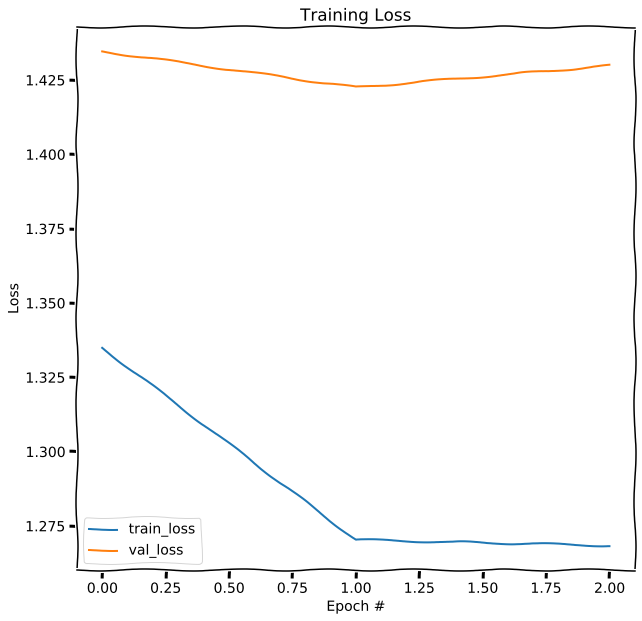

In [49]:
plot_training(history)